Circuit Summary:

Results (Target state was 1): {'000': 1000}


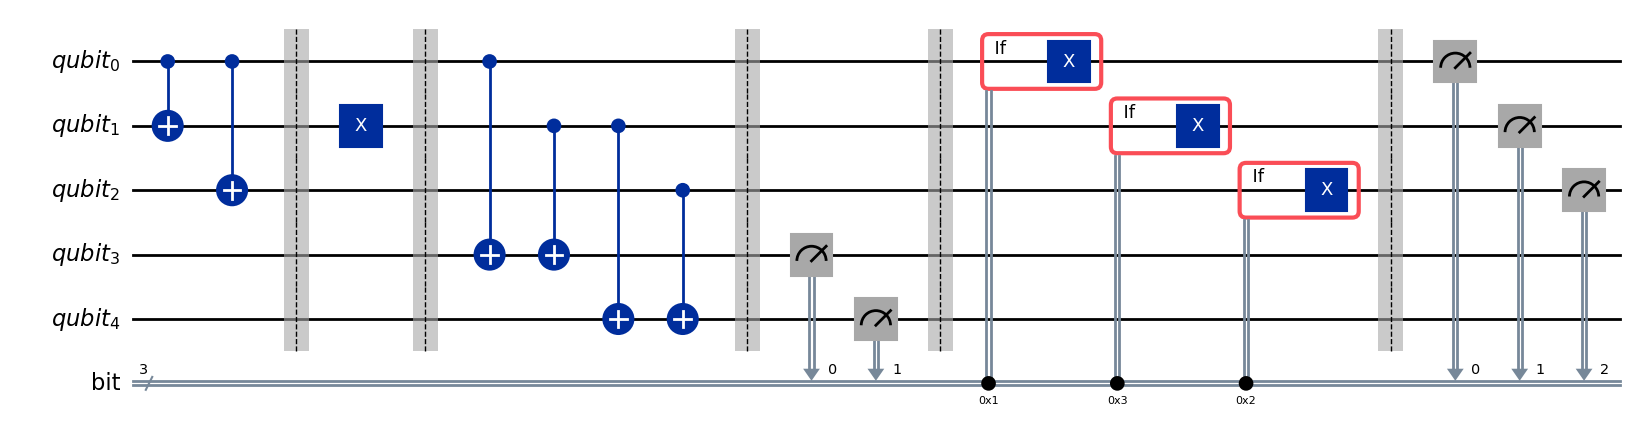

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import circuit_drawer

# 1. Setup Registers
# We use 3 qubits for the code, 2 ancilla qubits, 2 ancilla classical bits, and 1 classical bit for the result
q = QuantumRegister(5, 'qubit')
c = ClassicalRegister(3, 'bit')
qc = QuantumCircuit(q, c)

# You can also play with the following
# qc.x(q[0]) sets initial state to |1>
# qc.h(q[0]) sets initial state to (|0> + |1>) / sqrt(2)

# --- STEP 1: ENCODING ---
# Spread the state to qubit 1 and 2 (Encoding |1> into |111>)
qc.cx(q[0], q[1])
qc.cx(q[0], q[2])
qc.barrier()

# --- STEP 2: INTRODUCE ERROR ---
# We simulate an error by flipping qubit 1. 
# You can change this to q[0] or q[2] and the code will still work!
qc.x(q[1]) 
qc.barrier()

# --- STEP 3: DETECTION & CORRECTION ---
# Heart of the correction code
qc.cx(q[0], q[3])
qc.cx(q[1], q[3])
qc.cx(q[1], q[4])
qc.cx(q[2], q[4])
qc.barrier()

qc.measure(q[3], c[0])
qc.measure(q[4], c[1])
qc.barrier()

# Flip first qubit if c[0] = 1 and c[1] = 0
with qc.if_test((c, 1)):
    qc.x(q[0])

# Flip second qubit if c[0] = 1 and c[1] = 1
with qc.if_test((c, 3)):
    qc.x(q[1])

# Flip third qubit if c[0] = 0 and c[1] = 1
with qc.if_test((c, 2)):
    qc.x(q[2])
qc.barrier()

# I'm not sure if we really need this because Gemini did this
# The Toffoli gate (CCX) flips qubit 0 back if BOTH q1 and q2 are 1.
# This effectively performs a "majority vote" correction.
# qc.ccx(q[2], q[1], q[0])
# qc.barrier()

# --- STEP 4: MEASUREMENT ---
# We measure the corrected logical qubits
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.measure(q[2], c[2])

# --- EXECUTION ---
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=1000)
result = job.result()
counts = result.get_counts()

print("Circuit Summary:")
# print(qc.draw(output='text'))
print(f"\nResults (Target state was 1): {counts}")
qc.draw("mpl")